In [2]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import mplhep as hep
import pandas as pd
hep.style.use(hep.style.CMS)
import hist as hist2

from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.nanoevents.methods import candidate, vector
from coffea.analysis_tools import Weights, PackedSelection

# we suppress ROOT warnings where our input ROOT tree has duplicate branches - these are handled correctly.
import warnings
import uproot
from coffea import processor
import warnings

warnings.filterwarnings('ignore')

In [48]:
class triggerEffWbProcessor(processor.ProcessorABC):
    def __init__(self):
        self.make_output = lambda: {
            'pt_m_tr': hist2.Hist(
                hist2.axis.Regular(20, 30, 500, name='pt_m_tr'),
                ),
            'pt_m_tc': hist2.Hist(
                hist2.axis.Regular(20, 30, 500, name='pt_m_tc'),
                ),
            'eta_m_tr': hist2.Hist(
                hist2.axis.Regular(20, -2.4, 2.4, name='eta_m_tr'),
                ),
            'eta_m_tc': hist2.Hist(
                hist2.axis.Regular(20,-2.4, 2.4, name='eta_m_tc'),
                ),
            'met_tr': hist2.Hist(
                hist2.axis.Regular(20, 50, 500, name='met_tr'),
                ),
            'met_tc': hist2.Hist(
                hist2.axis.Regular(20, 50, 500, name='met_tc'),
                ),
            'pt_bjet_tr': hist2.Hist(
                hist2.axis.Regular(20, 30, 500, name='pt_bjet_tr'),
                ),
            'pt_bjet_tc': hist2.Hist(
                hist2.axis.Regular(20, 30, 500, name='pt_bjet_tc'),
                ),
            'eta_bjet_tr': hist2.Hist(
                hist2.axis.Regular(30, -2.1, 2.1, name='eta_bjet_tr'),
                ),
            'eta_bjet_tc': hist2.Hist(
                hist2.axis.Regular(30, -2.1, 2.1, name='eta_bjet_tc'),
                ),
            'deltaR_tr': hist2.Hist(
                hist2.axis.Regular(100, 0, 10, name='deltaR_tr'),
                ),
            'deltaR_tc': hist2.Hist(
                hist2.axis.Regular(100, 0, 10, name='deltaR_tc'),
                )
            
        }
    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):
        dataset = events.metadata['dataset']
        #weights = Weights(len(events), storeIndividual=True)
        #weights.add('genweight', events.genWeight)
        
        selection = PackedSelection()
        
        
        
        output =self.make_output()
        output['sum'] = len(events)
        events1 = events[(ak.sum(events.Muon.pt>0, axis=1)==1)]
        b_jet=events1.Jet[(events1.Jet.jetId==6) & (events1.Jet.puId==7) & (events1.Jet.btagDeepFlavB>0.4506)]
        events1["bjet"]=b_jet
        bjets = events1.bjet
        muons = events1.Muon
        muon_bjet_pairs = ak.cartesian({"muon": muons, "bjet": bjets})
        muon_bjet_delta_r = muon_bjet_pairs["muon"].delta_r(muon_bjet_pairs["bjet"])
        events1["deltaR"] = muon_bjet_delta_r
        events1 = events1[(ak.sum(events1.TrigObj.id==11, axis=1)==1)]
       
        
        
        
        #trigger
        
        trigger_de_ref=events1.HLT.Ele35_WPTight_Gsf
        trigger_central=events1.HLT.IsoMu27
        
        #events["heepmuon"]=events.Muon[events.Muon.mediumId]
        #events["heepmuon"]=ak.sum(events.Muon.highPtId>0, axis=1)==2
        # Identifier Muon electron
        events1["heepmuon"]=events1.Muon[events1.Muon.tightId]
        events1["heeplecton"]=events1.Electron[events1.Electron.cutBased_HEEP]
        
        
        #Muon
        #& (ak.sum(events.Muon.highPtId>0, axis=1)==2)
        goodmuon = ((ak.sum(events1.heepmuon.pt>0, axis=1)==1)
                &((ak.pad_none(events1.heepmuon.pt,1)[:,0]>30))
                & ((abs(ak.pad_none(events1.heepmuon.eta,2)[:,0])<2.4))
                )
        #tomar los eventos de un solo un muon
        #aplico a todos los enventos
        
        
        
        #events["deltaR"] = events[ak.any(muon_bjet_delta_r > 1.7, axis=1)]
        
                       
        #electron & (ak.sum(events.Electron.cutBased>0, axis=1)==2)
        goodelectron = ((ak.sum(events1.heeplecton.pt>0, axis=1)==1)
                        &((ak.pad_none(events1.heeplecton.pt, 1)[:,0]>30))
                        &(((0<abs(ak.firsts(events1.heeplecton.eta))) & (abs(ak.firsts(events1.heeplecton.eta))<2.4))
                        & ((1.57<abs(ak.firsts(events1.heeplecton.eta))) | (abs(ak.firsts(events1.heeplecton.eta))<1.4)))
                #&((ak.pad_none(events.Electron.charge, 2)[:,0])!=(ak.pad_none(events.Electron.charge, 2)[:,1]))
                )
        
        #b-jet
        
        goodbJets = ((ak.sum(events1.bjet.pt>0, axis=1)==1)
            &((ak.firsts(events1.bjet.pt)>30)
            &(abs(ak.firsts(events1.bjet.eta))<2.1)
             ))
        
        #met
        
        #goodMet=events.MET.pt>50
        
        #delta_R
        
        goodelta = (ak.all(events1.deltaR > 0.5, axis=1)==1)
        
        #seleccion
        
        selection.add("trigger_de_ref",trigger_de_ref)
        selection.add("trigger_central",trigger_central)
        #selection.add("trigger_central_muon", trigger_central_muon)
        selection.add("muon",goodmuon)
        selection.add("bJet",goodbJets)
        selection.add("electron",goodelectron)
        selection.add("deltaR",goodelta)
        #selection.add("Met",goodMet)
        
        #regions
        
        
        regions={"signal_trigger":["trigger_de_ref"],
         "signal_trigger_e":["trigger_de_ref","muon"],
         "signal_trigger_e_bjet":["trigger_de_ref","muon","bJet"],
         "signal_triggerref_e_bjet_met":["deltaR","electron","muon","bJet","trigger_de_ref"],
         "signal_triggerctl_e_bjet_met":["deltaR","electron","muon","bJet","trigger_de_ref","trigger_central"],
                }
        
        #candidates
        
        candidtae_events_ref=events1[selection.all(*regions["signal_triggerref_e_bjet_met"])]
        candidtae_events_ctl=events1[selection.all(*regions["signal_triggerctl_e_bjet_met"])]
        
      
        
            
        #selection out
        # pt m
        output['pt_m_tr'].fill(pt_m_tr = ak.firsts(candidtae_events_ref.heepmuon.pt))
        output['pt_m_tc'].fill(pt_m_tc = ak.firsts(candidtae_events_ctl.heepmuon.pt))
        
        #eta m
        output['eta_m_tr'].fill(eta_m_tr = ak.firsts(candidtae_events_ref.heepmuon.eta))
        output['eta_m_tc'].fill(eta_m_tc = ak.firsts(candidtae_events_ctl.heepmuon.eta))
        
        #Met
        output['met_tr'].fill(met_tr = candidtae_events_ref.MET.pt)
        output['met_tc'].fill(met_tc = candidtae_events_ctl.MET.pt)
        
        #pt bjet
        output['pt_bjet_tr'].fill(pt_bjet_tr = ak.firsts(candidtae_events_ref.bjet.pt))
        output['pt_bjet_tc'].fill(pt_bjet_tc = ak.firsts(candidtae_events_ctl.bjet.pt))
        
        #eta bjet
        
        output['eta_bjet_tr'].fill(eta_bjet_tr = ak.firsts(candidtae_events_ref.bjet.eta))
        output['eta_bjet_tc'].fill(eta_bjet_tc = ak.firsts(candidtae_events_ctl.bjet.eta))
        
        #delta R
        
        output['deltaR_tr'].fill(deltaR_tr = ak.firsts(candidtae_events_ref.deltaR))
        output['deltaR_tc'].fill(deltaR_tc= ak.firsts(candidtae_events_ctl.deltaR))
       
        
        
        
        return {dataset: output}
            
    def postprocess(self, accumulator):
        return accumulator

In [49]:
import json
 
# Opening JSON file
f = open("./fileset/singleelectron.txt")
 
# returns JSON object as
# a dictionary
load_data = json.load(f)
datos=[]

#for i in range(2):
    #datos.append("root://xcache/"+load_data["SingleElectron"][i])

for i in load_data["SingleElectron"]:
    datos.append("root://xcache/"+i)

In [50]:
len(datos)

272

In [51]:
fileset={'TTT':datos}

In [56]:
out = processor.run_uproot_job(
    fileset,
    treename="Events",
    processor_instance=triggerEffWbProcessor(),
    executor=processor.futures_executor,
    executor_args={
        "schema": processor.NanoAODSchema,
         "workers": 58
        #"client": client,
    },
        
    )

Preprocessing:   0%|          | 0/270 [00:00<?, ?file/s]

Processing:   0%|          | 0/3515 [00:00<?, ?chunk/s]

In [60]:
def get_value(den):
    return den.values()

def get_axis(den):
    return [den.axes.bin(i)[0][0] for i in range(len(den.values())+1)]

In [61]:
def graficar_hist(data,labels,namesave,xmin=0,xmax=600):
    plt.plot(igsize=(12, 4))
    hep.cms.lumitext("(13 TeV)")
    hep.cms.text("Work in Progress")
    hep.histplot(data.values(),bins=np.array(get_axis(data)),
                 color="black",density=False,label=labels)
    plt.xlim(xmin,xmax)
    plt.legend()
    plt.xlabel(labels)
    #plt.savefig(namesave)

In [62]:
from hist.intervals import clopper_pearson_interval
def error(num, den):
    return abs(
        clopper_pearson_interval(num.values(), den.values()) - num.values() / den.values()
    )

def graf_eficience(num,den,labels,namesave,bar_error=False,ymin=0.8,ymax=1.03,xmin=0,xmax=600):
    hep.cms.lumitext("(13 TeV)")
    hep.cms.text("Work in Progress")
    eficience=np.array(num.values()/den.values())
    bines=np.array(get_axis(num))
    eficience[np.isnan(eficience)] = 0
    hep.histplot(eficience,bins=bines,label=labels)
    
    if bar_error:
        el_err = error(num, den)
        hep.histplot(eficience,bins=bines,yerr=el_err,histtype='errorbar',fmt="ko",
             capsize=3,label="error")    
    
    plt.ylim(ymin,ymax)
    plt.xlim(xmin,xmax)
    plt.legend()
    plt.xlabel(labels)
    #plt.savefig(namesave)

In [63]:
pt_m_tr=out["TTT"]["pt_m_tr"]
pt_m_tc=out["TTT"]["pt_m_tc"]

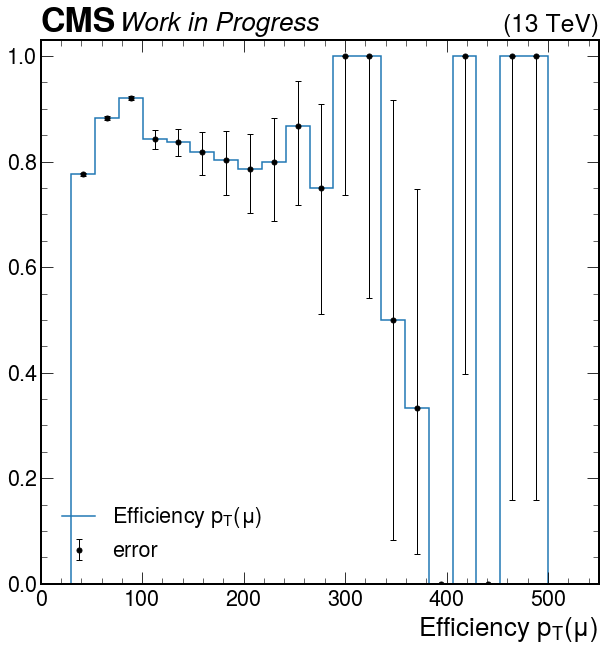

In [64]:
graf_eficience(pt_m_tc,pt_m_tr,bar_error=True,
               labels="Efficiency ${p}_{T}(\mu)$",
               namesave="./graf_11_02/Efficiency_pt_e.jpg",
              xmin=0,xmax=550,ymin=0)

In [65]:
eta_m_tr=out["TTT"]["eta_m_tr"]
eta_m_tc=out["TTT"]["eta_m_tc"]

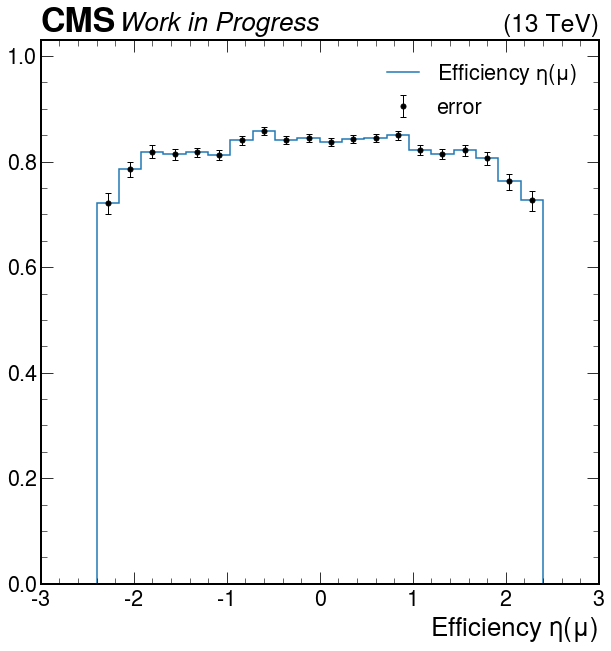

In [66]:
graf_eficience(eta_m_tc,eta_m_tr,bar_error=True,labels="Efficiency $\eta (\mu)$",
               namesave="./graf_11_02/Efficiency_eta_e.jpg",
              xmin=-3,xmax=3,ymin=0)

In [67]:
pt_bjet_tr=out["TTT"]["pt_bjet_tr"]
pt_bjet_tc=out["TTT"]["pt_bjet_tc"]

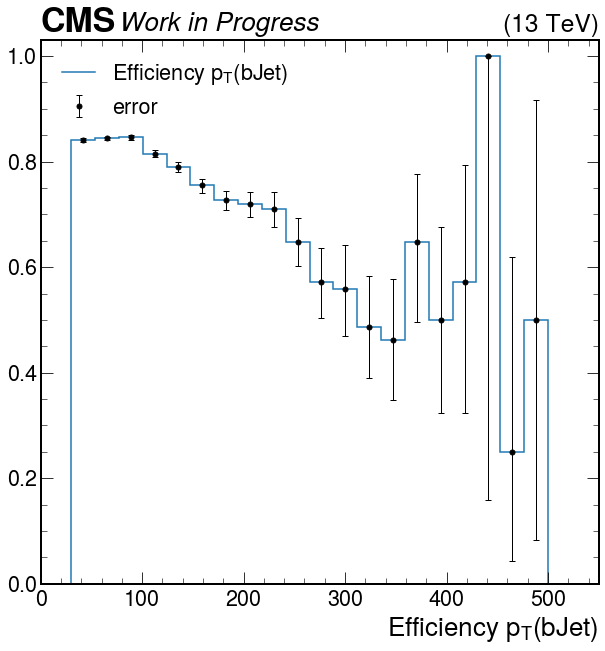

In [68]:
graf_eficience(pt_bjet_tc,pt_bjet_tr,bar_error=True,
               labels="Efficiency ${p}_{T}(bJet)$",
               namesave="./graf_11_02/Efficiency_pt_bjet.jpg",
              xmin=0,xmax=550,ymin=0)

In [69]:
eta_bjet_tr=out["TTT"]["eta_bjet_tr"]
eta_bjet_tc=out["TTT"]["eta_bjet_tc"]